In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import itertools
import numpy as np
from scipy import stats

sns.set(style="ticks", font="Arial", font_scale=1.3)

In [2]:
CONDS = [
    "probable", "improbable", 
    "impossible_physics", "impossible_magic", 
    "inconceivable_semantic", "inconceivable_syntactic"
]
LABELS = [
    "probable", "improbable", "impossible", "nonsense"
]
PRETTY_COND_MAP = {
    "probable": "Probable",
    "improbable": "Improbable",
    "impossible_physics": "Impossible (physics)", 
    "impossible_magic": "Impossible (magic)", 
    "inconceivable_semantic": "Inconceivable (semantics)", 
    "inconceivable_syntactic": "Inconceivable (syntax)" 
}
PRETTY_CONDS = [PRETTY_COND_MAP[c] for c in CONDS]
PRETTY_LABELS = [l.capitalize() for l in LABELS]

MODELS = ["gpt2", "meta-llama/Llama-2-7b-hf", "mistralai/Mistral-7B-v0.1"]
PRETTY_MODELS = ["GPT-2", "Llama-2 7B", "Mistral 7B"]

darkblue, lightblue = "#6E7CB9FF", "#7BBCD5FF"
darkred, lightred = "#ef435e", "#f79f99"
darkorange, lightorange = "#F9AB0EFF", "#FBC559FF"
COND_PAL = {
    "probable": darkblue,
    "improbable": lightblue,
    "impossible_physics": darkorange,
    "impossible_magic": lightorange,
    "inconceivable_semantic": darkred,
    "inconceivable_syntactic": lightred,
}

def render(outpath=None):
    if outpath is not None:
        plt.savefig(f"../figures/{outpath}", dpi=300, bbox_inches="tight")

# Experiment 1: Human classification task

In [3]:
# Helper function for labeling whether a response matches the underlying condition.
def is_correct(response, condition):
    condition_coarse = condition.split("_")[0]
    if response == condition_coarse:
        return True
    elif response == "nonsense" and condition_coarse == "inconceivable":
        return True
    else:
        return False

exp1 = pd.read_csv("../data/exp1_human_classification/critical.csv")
exp1["response_correct"] = exp1.apply(
    lambda r: is_correct(r.response_label, r.condition),
    axis=1
)
print(f"Experiment 1: {exp1.subject_id.nunique()} unique subjects")

Experiment 1: 30 unique subjects


## Figure 1a

condition
impossible_magic           0.740000
impossible_physics         0.553333
improbable                 0.586667
inconceivable_semantic     0.773333
inconceivable_syntactic    0.986667
probable                   0.966667
Name: response_correct, dtype: float64

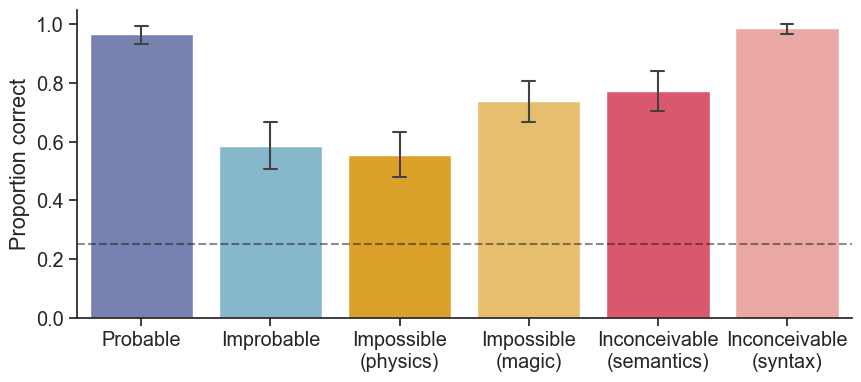

In [4]:
ax = sns.barplot(
    data=exp1, 
    x="condition", 
    y="response_correct", 
    hue="condition",
    legend=False,
    order=CONDS, 
    palette=COND_PAL,
    capsize=0.1,
    err_kws=dict(linewidth=1.5)
)
ax.set_xticks(range(len(CONDS)))
ax.set_xticklabels([c.replace(" ", "\n") for c in PRETTY_CONDS])
ax.set_xlabel("")
ax.set_ylabel("Proportion correct")
ax.axhline(0.25, linestyle="--", color="k", alpha=0.5)
plt.gcf().set_size_inches(10,4)
sns.despine()
render("fig1a_exp1_proportion_correct.pdf")
exp1.groupby("condition").response_correct.mean()

## Figure 1b

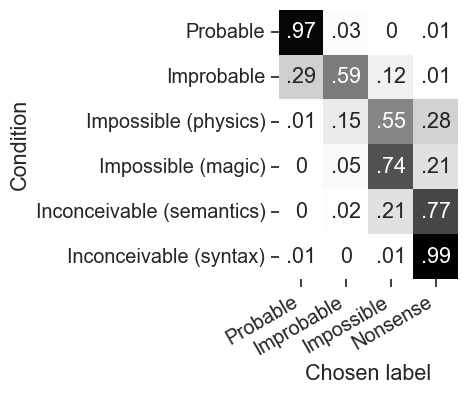

In [5]:
confusion = np.ones((len(CONDS), len(LABELS)))
annot = []
for i, cond in enumerate(CONDS):
    cond_rows = exp1[exp1.condition==cond]
    annot_row = []
    for j, label in enumerate(LABELS):
        # get rows with this ground-truth condition, and this predicted label
        rows = cond_rows[cond_rows.response_label==label] 
        confusion[i][j] = len(rows) / len(cond_rows)
        s = f"{confusion[i][j]:.2f}"
        if s == "0.00":
            s = "0"
        elif s == "1.00":
            s = "1"
        elif s.startswith("0."):
            s = s[1:]
        annot_row.append(s)
    annot.append(annot_row)

ax = sns.heatmap(confusion, annot=annot, cmap="Greys", fmt="", square=True, cbar=False)
ax.set_yticklabels(PRETTY_CONDS, rotation=0)
ax.set_ylabel("Condition")
ax.set_xticklabels(PRETTY_LABELS, rotation=30, ha="right")
ax.set_xlabel("Chosen label")
plt.gcf().set_size_inches(5,3.5)
render("fig1b_exp1_confusion_matrix.pdf")

# Experiment 2: Language model surprisal

In [6]:
model_df = pd.concat([
    pd.read_csv(f"../data/exp2_model_surprisal/surprisals/{model.split('/')[-1].lower()}.csv")
    for model in MODELS
])
model_df.head()

,item_id,prefix,eval_prefix,condition,continuation,continuation_tokens,continuation_sum_surprisal,model
0,1,Baking a cake using,He baked a cake using,probable,an oven.,Ġan Ġoven .,9.577380,gpt2
1,1,Baking a cake using,He baked a cake using,improbable,an airfryer.,Ġan Ġair f ry er .,22.057408,gpt2
2,1,Baking a cake using,He baked a cake using,impossible_physics,a refrigerator.,Ġa Ġrefrigerator .,13.174368,gpt2
3,1,Baking a cake using,He baked a cake using,impossible_magic,superpowers.,Ġsuper powers .,15.808425,gpt2
4,1,Baking a cake using,He baked a cake using,inconceivable_syntactic,grasp.,Ġgrasp .,18.861928,gpt2


In [7]:
ngrams = pd.read_csv("../data/exp2_model_surprisal/ngram_freqs.csv") 
ngrams["log_joint_count"] = np.log(ngrams.joint_count)
ngrams.head()

/Users/jenniferhu/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,item_id,prefix,infinitive_prefix,expt_prefix,sentence_prefix,prefix_type,condition,continuation,joint_count,cond_count,event_unigram_count,cond_prob,joint_prob,log_joint_count
0,1,Baking a cake using,bake a cake using,Can you bake a cake using,[NP] baked a cake using,tool,probable,an oven,167704,679253970,2878189,2.468944e-04,6.482273e-07,12.029956
1,1,Baking a cake using,bake a cake using,Can you bake a cake using,[NP] baked a cake using,tool,improbable,an airfryer,0,679253970,0,0.000000e+00,0.000000e+00,-inf
2,1,Baking a cake using,bake a cake using,Can you bake a cake using,[NP] baked a cake using,tool,impossible_physics,a refrigerator,146693,3902120543,1528971,3.759315e-05,5.670134e-07,11.896097
3,1,Baking a cake using,bake a cake using,Can you bake a cake using,[NP] baked a cake using,tool,impossible_magic,superpowers,257839,258711708208,257839,9.966267e-07,9.966267e-07,12.460091
4,1,Baking a cake using,bake a cake using,Can you bake a cake using,[NP] baked a cake using,tool,inconceivable_syntactic,grasp,3655805,258711708208,3655805,1.413081e-05,1.413081e-05,15.111827


In [8]:
# Combine surprisal and ngram frequency data.
index = ["item_id", "condition"]
new_ngrams = ngrams.set_index(index)[["log_joint_count", "joint_prob"]]
model_df_with_ngrams = model_df.set_index(index).join(new_ngrams, on=index).reset_index()
model_df_with_ngrams.to_csv("../data/exp2_model_surprisal/surprisal_ngram_data.csv", index=False)

## Figure 2

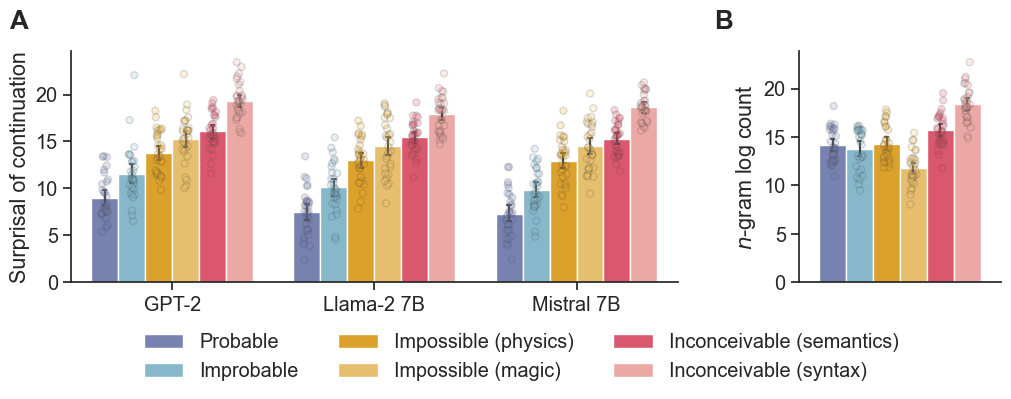

In [9]:
def plot_surprisals_freqs(df, ngrams, freq_stat="log_joint_count"):
    # Set up subplots.
    fig, axes = plt.subplots(
        nrows=1, ncols=2, 
        sharex=False, sharey=False, 
        figsize=(12,3), 
        gridspec_kw={'width_ratios': [3, 1]}
    )
    ax0, ax1 = axes
    
    # Common keywords for stripplots and barplots.
    strip_kws = dict(alpha=0.2, linewidth=1, dodge=True, legend=False)
    bar_kws = dict(capsize=0.1, err_kws=dict(linewidth=1.5))
    
    # Plot surprisals across conditions on the first axis.
    surp_kws = dict(
        data=df, 
        x="model", 
        y="continuation_sum_surprisal",
        order=MODELS,
        hue="condition", 
        hue_order=CONDS,
        palette=COND_PAL,
        ax=ax0
    )
    ax0 = sns.barplot(**surp_kws, **bar_kws)
    ax0 = sns.stripplot(**surp_kws, **strip_kws)
    ax0.set_ylabel("Surprisal of continuation")
    ax0.set_xlabel("")
    ax0.set_xticks(range(len(MODELS)))
    ax0.set_xticklabels(PRETTY_MODELS)
    ax0.get_legend().remove()
    
    # Plot ngram frequencies across conditions on the second axis.
    freq_kws = dict(
        data=ngrams, 
        y=freq_stat, 
        hue="condition", 
        hue_order=CONDS,
        palette=COND_PAL,
        ax=ax1
    )
    ax1 = sns.barplot(**freq_kws, **bar_kws)
    ax1 = sns.stripplot(**freq_kws, **strip_kws)

    ax1.set_xlabel("")
    ax1.set_ylabel("$n$-gram log count")
    ax1.set_xticks([])
    ax1.get_legend().remove()
    
    handles, labels = ax0.get_legend_handles_labels()
    labels = [PRETTY_COND_MAP[l] for l in labels]
    plt.figlegend(
        handles,
        labels, 
        loc="upper center", bbox_to_anchor=(0.5, 0), ncol=3,
        frameon=False
    )
    plt.subplots_adjust(wspace=0.3)
    sns.despine()
    
    # Add annotations of A and B.
    ax0.text(-0.8, 27, "A", size="large", fontweight="bold")
    ax0.text(2.68, 27, "B", size="large", fontweight="bold")

plot_surprisals_freqs(model_df, ngrams)
render("fig2_exp2_surprisals_ngrams.pdf")

## Figure 3

/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_95717/3972645784.py:33: PerformanceWarning: indexing past lexsort depth may impact performance.
  mat[i][j] = m_df.loc[cond1, cond2].comparison_outcome.mean()
/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_95717/3972645784.py:33: PerformanceWarning: indexing past lexsort depth may impact performance.
  mat[i][j] = m_df.loc[cond1, cond2].comparison_outcome.mean()
/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_95717/3972645784.py:33: PerformanceWarning: indexing past lexsort depth may impact performance.
  mat[i][j] = m_df.loc[cond1, cond2].comparison_outcome.mean()


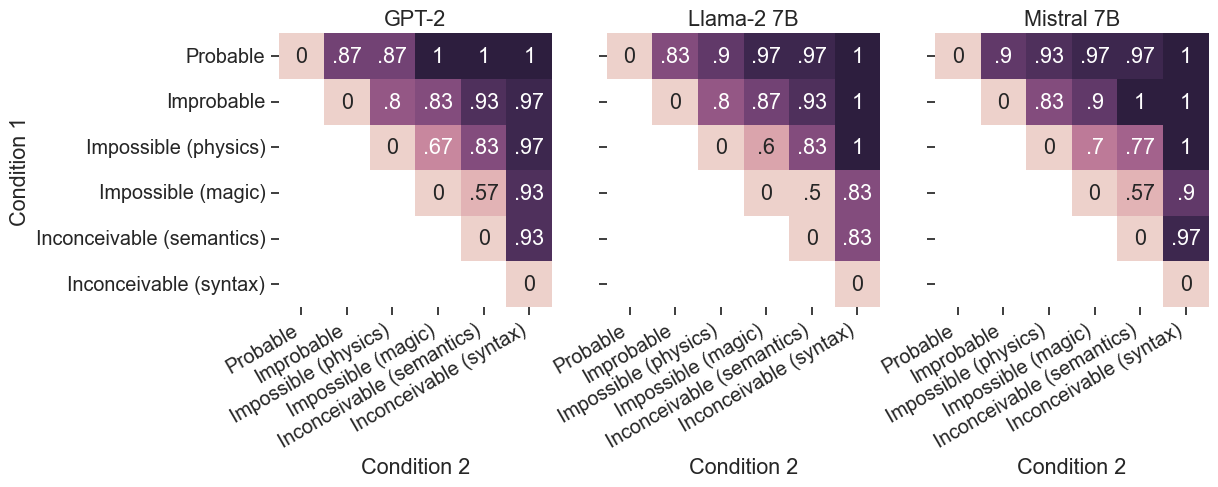

In [10]:
def compute_item_level_scores(df):
    data = []
    for model in df.model.unique():
        m_df = df[df.model==model].set_index(["item_id"])
        for item in m_df.index.unique():
            rows = m_df.loc[item].set_index("condition")
            # Get all combinations of condition pairs.
            for cond1, cond2 in itertools.product(df.condition.unique(), repeat=2):
                res = {"item_id": item, "model": model, "cond1": cond1, "cond2": cond2}
                cond1_label = PRETTY_COND_MAP[cond1]
                cond2_label = PRETTY_COND_MAP[cond2]
                res["cond1_label"] = cond1_label
                res["cond2_label"] = cond2_label
                comparison_name = f"{cond1_label} < {cond2_label}"
                comparison_val = (
                    rows.loc[cond1].continuation_sum_surprisal < 
                    rows.loc[cond2].continuation_sum_surprisal
                )
                res["comparison"] = comparison_name
                res["comparison_outcome"] = comparison_val
                data.append(res)
    data = pd.DataFrame(data)
    return data

def get_heatmap_data(df):
    mats = {}
    for model in df.model.unique():
        m_df = df[df.model==model].set_index(["cond1", "cond2"])
        n_conds = len(CONDS)
        mat = np.zeros((n_conds, n_conds))
        for i, cond1 in enumerate(CONDS):
            for j, cond2 in enumerate(CONDS):
                mat[i][j] = m_df.loc[cond1, cond2].comparison_outcome.mean()
        mats[model] = mat
    return mats

within_item_comparison = compute_item_level_scores(model_df)
heatmap_data = get_heatmap_data(within_item_comparison)
fig, axes = plt.subplots(nrows=1, ncols=len(MODELS), sharey=False, sharex=True)
for i, model in enumerate(MODELS):
    ax = axes[i]
    mat = heatmap_data[model]
    # Manually tweaked annotations.
    annot = []
    for row in mat:
        annot_row = []
        for x in row:
            s = f"{x:.2g}"
            if s.startswith("0."):
                s = s.replace("0.", ".")
            annot_row.append(s)
        annot.append(annot_row)
    pal = sns.cubehelix_palette(as_cmap=True)
    mask = np.tril(np.ones_like(mat))
    np.fill_diagonal(mask, False)
    ax = sns.heatmap(
        ax=ax,
        data=mat,
        mask=mask,
        vmin=0.5, 
        vmax=1, 
        cmap=pal, 
        annot=annot, 
        fmt="", 
        cbar=False, 
        square=True
    )
    ax.set_title(PRETTY_MODELS[i])
    ax.set_xticklabels(PRETTY_CONDS, rotation=30, ha="right")
    ax.set_xlabel("Condition 2")
    if i==0:
        ax.set_yticklabels(PRETTY_CONDS, rotation=0)
        ax.set_ylabel("Condition 1")
    else:
        ax.set_yticklabels([])

plt.subplots_adjust(wspace=0.2)
plt.gcf().set_size_inches(12,4)
render("fig3_exp2_item_level_surprisal_comparison_heatmap.pdf")

# Experiment 3: Possibility judgments

In [11]:
def is_correct(response, condition):
    condition_coarse = condition.split("_")[0]
    if condition_coarse in ["probable", "improbable"] and response == 1:
        return True
    elif condition_coarse in ["impossible", "inconceivable"] and response == 0:
        return True
    else:
        return False

exp3 = pd.read_csv("../data/exp3_human_rt/critical.csv")
exp3["response_correct"] = exp3.apply(
    lambda r: is_correct(r.response, r.condition),
    axis=1
)
print(f"Experiment 3: {exp3.subject_id.nunique()} unique subjects")
exp3_practice = pd.read_csv("../data/exp3_human_rt/practice.csv")

Experiment 3: 299 unique subjects


In [12]:
def remove_outliers(df, col, method="zscore"):
    if method == "zscore":
        mask = (np.abs(stats.zscore(df[col])) < 2)
        df = df[mask]
        return df
    elif method == "iqr":
        iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
        low = df[col].quantile(0.25) - 1.5*iqr
        high = df[col].quantile(0.75) + 1.5*iqr
        return df[(df[col]>=low)&(df[col]<=high)]
    else:
        raise ValueError("Method should be 'zscore' or 'iqr'")

def exclude_participants(df, practice_data, accuracy_threshold=0.8, comprehension_threshold=3):
    # Only keep people above a certain threshold of accuracy.
    orig_num_participants = df.subject_id.nunique()
    subj_acc = df.groupby("subject_id").response_correct.mean()
    subj_to_keep = subj_acc[subj_acc >= accuracy_threshold].index
    excluded_num_participants = orig_num_participants - len(subj_to_keep)
    excluded_prop_participants = excluded_num_participants / orig_num_participants
    print(
        "Accuracy:",
        f"Excluded {excluded_num_participants} / {orig_num_participants} ({excluded_prop_participants:.3f})")
    df = df[df.subject_id.isin(subj_to_keep)]
    
    # Only keep people with reasonable variance in RT.
    subj_rt_std = df.groupby("subject_id").rt.std()
    subj_rt_std_no_outliers = remove_outliers(subj_rt_std.reset_index(), "rt")
    subj_to_keep = subj_rt_std_no_outliers.subject_id
    excluded_num_participants = orig_num_participants - len(subj_to_keep)
    excluded_prop_participants = excluded_num_participants / orig_num_participants
    print(
        "Response time variation:",
        f"Excluded {excluded_num_participants} / {orig_num_participants} ({excluded_prop_participants:.3f})")
    df = df[df.subject_id.isin(subj_to_keep)]

    # Only keep people who passed the comp check within 3 attempts.
    num_comp_attempts = practice_data.groupby("subject_id").attempts.max()
    subj_to_keep = num_comp_attempts[num_comp_attempts <= comprehension_threshold].index
    excluded_num_participants = orig_num_participants - len(subj_to_keep)
    excluded_prop_participants = excluded_num_participants / orig_num_participants
    print(
        "Comprehension check:",
        f"Excluded {excluded_num_participants} / {orig_num_participants} ({excluded_prop_participants:.3f})")
    df = df[df.subject_id.isin(subj_to_keep)]
    
    print("Final total number of participants:", df.subject_id.nunique())
    return df

exp3_clean = exclude_participants(exp3, exp3_practice)

Accuracy: Excluded 17 / 299 (0.057)
Response time variation: Excluded 21 / 299 (0.070)
Comprehension check: Excluded 33 / 299 (0.110)
Final total number of participants: 247


In [13]:
def remove_rt_outliers_within_participant(df):
    # Normalize RTS within participant.
    subj_rt_data = df.groupby("subject_id").rt.describe()
    df["rt_normalized"] = df.apply(
        lambda r: (r.rt - subj_rt_data.loc[r.subject_id, "mean"]) / subj_rt_data.loc[r.subject_id, "std"],
        axis=1
    )
    # Remove rows 3 std. dev. away from participant mean.
    df = df[(df.rt_normalized < 3) & (df.rt_normalized > -3)]
    return df
    
exp3_no_rt_outlier = remove_rt_outliers_within_participant(exp3_clean)
exp3_no_rt_outlier.to_csv("../data/exp3_human_rt/critical_clean.csv", index=False)

## Figure 4

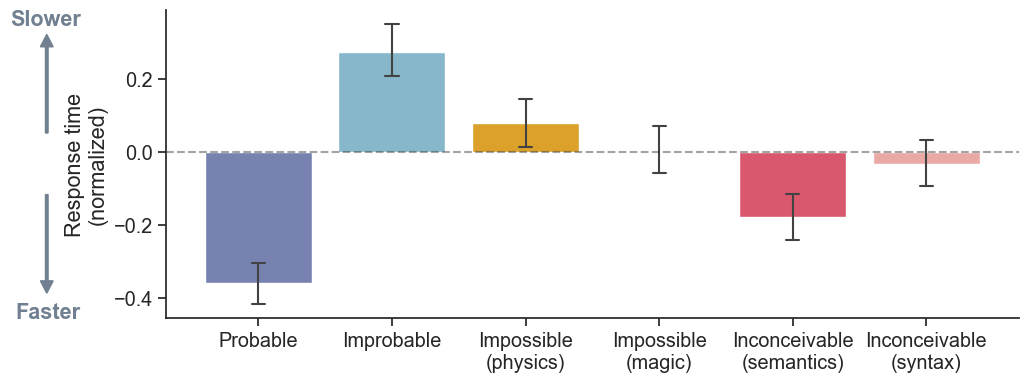

In [14]:
ax = sns.barplot(
    data=exp3_no_rt_outlier, 
    x="condition", 
    y="rt_normalized", 
    hue="condition",
    legend=False,
    order=CONDS, 
    palette=COND_PAL,
    capsize=0.1,
    err_kws=dict(linewidth=1.5)
)
ax.set_xticks(range(len(PRETTY_CONDS)))
ax.set_xticklabels([c.replace(" ", "\n") for c in PRETTY_CONDS]) # , rotation=25, ha="right")
ax.set_xlabel("")
ax.set_ylabel("Response time\n(normalized)")
ax.axhline(0, linestyle="--", color="k", alpha=0.4)
ax.text(-0.1, 0.95, "Slower", ha="right", transform=ax.transAxes, color="slategray", fontweight="bold")
ax.text(-0.1, 0, "Faster", ha="right", transform=ax.transAxes, color="slategray", fontweight="bold")
arrow_kws = dict(
    width=0.003, 
    transform=ax.transAxes, 
    clip_on=False, 
    color="slategray", 
    head_length=0.04, 
    head_width=0.015
)
ax.arrow(-0.14, 0.6, 0, 0.28, **arrow_kws)
ax.arrow(-0.14, 0.4, 0, -0.28, **arrow_kws)
plt.gcf().set_size_inches(11,4)
sns.despine()
render("fig4_exp3_rt_normalized_means.pdf")

## Figure 5

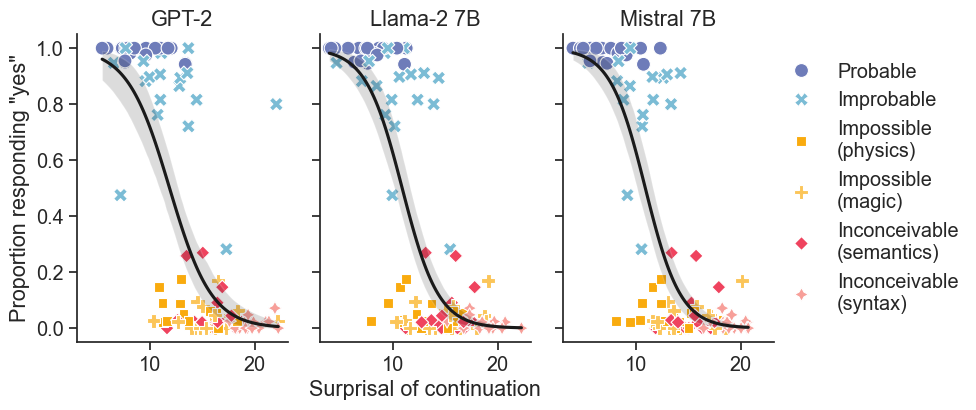

In [15]:
def judgments_vs_surprisal(data, model_df, ax=None, **kwargs):
    yes_data = data.groupby(["item_id", "condition"]).response.mean().reset_index()
    yes_data["item_id_cond"] = yes_data.item_id.astype(str) + "_" + yes_data.condition
    yes_data["surprisal"] = yes_data.apply(
        lambda r: model_df[(model_df.item_id==r.item_id)&(model_df.condition==r.condition)].continuation_sum_surprisal.item(),
        axis=1
    )
    if ax is None:
        ax = plt.gca()
    # Scatterplot the points.
    ax = sns.scatterplot(
        data=yes_data,
        x="surprisal",
        y="response",
        ax=ax,
        hue="condition",
        palette=COND_PAL,
        hue_order=CONDS,
        style="condition",
        style_order=CONDS,
        s=100
    )
    # Add regression line.
    ax = sns.regplot(
        data=yes_data,
        x="surprisal",
        y="response",
        logistic=True,
        ax=ax,
        scatter=False,
        color="k"
    )
    return ax

fig, axes = plt.subplots(nrows=1, ncols=len(MODELS), sharey=True, sharex=True, figsize=(9,4))
for i, model in enumerate(MODELS):
    ax = axes[i]
    ax = judgments_vs_surprisal(
        exp3_no_rt_outlier, 
        model_df[model_df.model==model],
        ax=ax
    )
    ax.set_title(PRETTY_MODELS[i])
    if i == 0:
        ax.set_ylabel("Proportion responding \"yes\"")
    else:
        ax.set_ylabel("")
    if i == 1:
        ax.set_xlabel("Surprisal of continuation")
    else:
        ax.set_xlabel("")
    sns.despine()
    if i != 2:
        ax.get_legend().remove()
    else:
        handles, labels = ax.get_legend_handles_labels()
        labels = [PRETTY_COND_MAP[l].replace(" ", "\n") for l in labels]
        ax.legend(handles, labels, loc='center left', bbox_to_anchor=(0.95, 0.5), frameon=False)
plt.subplots_adjust(wspace=0.15)
render("fig5_exp3_judgment_vs_surprisal.pdf")